In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from tqdm import trange
import subprocess

1. generate parameter files (define potentials && measure member galaxy properties)

In [2]:
# write par file

gals_cat = Table.read("./simulation/cluster_x.hdf5", path='lens')
zl = 0.3026

f = open("./modeling/2.par", "w")
f.writelines(
    ["runmode", '\n', '\t', "reference 3 0 0", '\n', '\t', "mass 3 1000 ", str(round(zl, 4)), " mass.fits", '\n', '\t', "image 1 1clump_gal.cat", '\n', '\t', "inverse 3 0.1", 
    '\n', '\t', "end", '\n', '\n'])
f.writelines(
    ["grille", '\n', '\t', "number 128", '\n', '\t', "polarie 0", '\n', '\t', "nlens ", str(len(gals_cat)+1), '\n', '\t', "nlens_opt 1", '\n', '\t', "end", '\n',
    '\n'])
f.writelines(
    ["image", '\n', '\t', "multfile 1 1clump_gal.cat", '\n', '\t', "forme -1", '\n', '\t', "sigposArcsec 0.1", '\n', '\t', "end", '\n',
    '\n'])
f.writelines(["potential 01", '\n', '\t', "profile 12", '\n', '\t', "x_centre 0.0", '\n', '\t', "y_centre 0.0",
            '\n', '\t', "ellipticite 0.1765", '\n', '\t', "angle_pos 15.0", '\n', '\t',
            "scale_radius_kpc 500.0", '\n', '\t', "v_disp 1500.0", '\n', '\t', "z_lens ", str(zl),
            '\n', '\t', "end", '\n', '\n'])
f.writelines(["limit 01", '\n', '\t', "x_centre 1 -6.0 6.0 0.1", '\n', '\t', "y_centre 1 -6.0 6.0 0.1",
            '\n', '\t', "scale_radius_kpc 1 100.0 2000.0 0.1", '\n', '\t', "v_disp 1 100.0 3000.0",
            '\n', '\t', "end", '\n', '\n'])
f.writelines(["potfile", '\n', '\t', "filein 3 galcat.cat", '\n', '\t', "zlens ", str(zl), '\n', '\t', "type 81",
            '\n', '\t', "corekpc 1.0", '\n', '\t', "mag0 20.0", '\n', '\t',
            "sigma 1 150.0 250.0", '\n', '\t', "cutkpc 1 1.0 30.0", '\n', '\t', "slope 0 3.125", '\n', '\t',  "vdslope 0 3.57",
            '\n', '\t', "end", '\n', '\n'])
f.writelines(
    ["cline", '\n', '\t', "nplan 1 2.0", '\n', '\t', "limitLow 1.0", '\n', '\t', "limitHigh 1.0", '\n', '\t', "end",
    '\n', '\n'])
f.writelines(
    ["cosmology", '\n', '\t', "H0 70.0", '\n', '\t', "omegaM 0.3", '\n', '\t', "omegaX 0.7", '\n', '\t',
    "wX -1.0", '\n', '\t', "end", '\n', '\n'])
f.writelines(["field", '\n', '\t', "dmax 90.0", '\n', '\t', "end", '\n', '\n'])
f.writelines(["fini"])
f.close()

In [3]:
# write member catalog
f_gal = open("./modeling/galcat.cat", "w")
f_gal.writelines(["#REFERENCE 3 0 0", '\n'])
for i in range(len(gals_cat['xlens1'])):
    f_gal.writelines([str(i+1), '\t', str(gals_cat['xlens1'][i]), '\t', str(gals_cat['xlens2'][i]), '\t', "1.0 ", 
                    str(gals_cat['qlens'][i]), '\t', str(gals_cat['pos_angle'][i]), '\t', str(gals_cat['magg'][i]), '\t', "0.0", '\n'])
f_gal.close()

2. call lenstool to model

spends ~4h to model on image plane

In [4]:
os.chdir("./modeling")
subprocess.run("lenstool 2.par -n", shell=True)
os.chdir("../")

INFO: 10010 good lines found in bayes.dat
COMP1: critic and caustic lines for source plane at z=2.000
limitHigh(in arcsec)=1.000 limitLow(in arcsec)=1.000
INFO: 10010 good lines found in bayes.dat



BayeSys3 return code 1

110.914168 2.627605 
110.914168 2.627605 
110.914168 2.627605 
110.914168 2.627605 
WRITE: FITS file: mass.fits[1000,1000] (-90.00:90.00 -90.00:90.00)


3. generate the magnification for the best parameter set

In [5]:
f = "./modeling/best.par"
new_line = "\tampli 2 1000 10.0 mag.fits\n" 
# change the number of 10.0, if you want to calculate the magnification at other redshifts

with open(f, "r") as file:
    lines = file.readlines()[12:]

del lines[2]
del lines[2]
if lines[-1].strip() == "finish":
    lines[-1] = 'fini\n'
lines.insert(2, new_line)

with open("./modeling/magn.par", "w") as file:
    file.writelines(lines)

In [6]:
os.chdir("./modeling")
subprocess.run("lenstool magn.par -n", shell=True)
os.chdir("../")

COMP1: critic and caustic lines for source plane at z=2.000
limitHigh(in arcsec)=1.000 limitLow(in arcsec)=1.000


WRITE: FITS file: mag.fits[1000,1000] (-90.00:90.00 -90.00:90.00)


4. plot

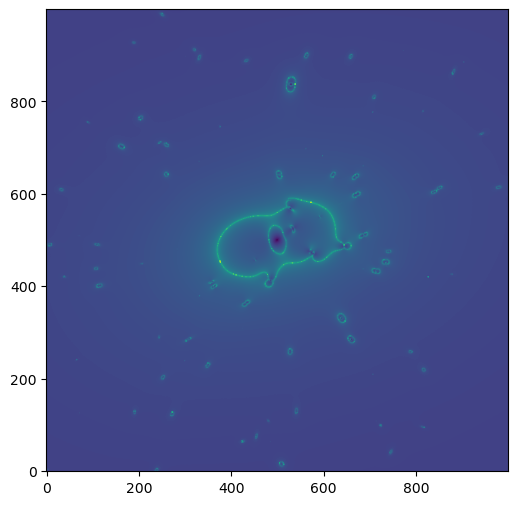

In [7]:
from matplotlib.colors import LogNorm
mag_10 = fits.open("./modeling/mag.fits")[0].data

plt.figure(figsize=(6, 6), dpi=100)
plt.imshow(mag_10, norm=LogNorm(), origin='lower')